# 1) Підготовка даних

## 1.1) Завантажити набір даних за посиланням https://www.kaggle.com/datasets/yasserhessein/gender-dataset

## 1.2) Підключити Google drive до середовища

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.3) Розпакувати набір даних в середовище

In [2]:
import zipfile
zip_ref = zipfile.ZipFile('drive/MyDrive/Colab Notebooks/gender-classifier/Dataset.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

## 1.4) Створити генератори даних для навчання, валідації і тестування моделі

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
batch_size = 32
target_size = (224, 224)
seed = 123

In [5]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )

In [ ]:
train_generator = train_datagen.flow_from_directory('Dataset/Train',
                                                    batch_size=batch_size ,
                                                    class_mode='binary',
                                                    seed=seed,
                                                    target_size=target_size)

Found 160000 images belonging to 2 classes.


In [ ]:
val_datagen = ImageDataGenerator( rescale = 1.0/255)

In [ ]:
validation_generator = val_datagen.flow_from_directory( 'Dataset/Validation',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          seed=seed,
                                                          target_size=target_size)

Found 22598 images belonging to 2 classes.


In [ ]:
test_generator = val_datagen.flow_from_directory( 'Dataset/Test',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          seed=seed,
                                                          target_size=target_size)

Found 20001 images belonging to 2 classes.


# 2) Створення моделі

In [11]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

## 2.1) Завантажити базову модель VGG16

In [2]:
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 2.2) Відключити можливість навчання базової моделі

In [3]:
base_model.trainable = False

## 2.3) Створити модель на основі базової моделі VGG16

In [4]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

## 2.4) Cкомпілювати модель

In [ ]:
model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 3) Навчання моделі

In [ ]:
history = model.fit(train_generator,
                validation_data=validation_generator,
                steps_per_epoch=500,
                epochs=20)

Epoch 1/20
500/500 [==============================] - 445s 873ms/step - loss: 0.4348 - accuracy: 0.8234 - val_loss: 0.2226 - val_accuracy: 0.9142
Epoch 2/20
500/500 [==============================] - 341s 682ms/step - loss: 0.3008 - accuracy: 0.8699 - val_loss: 0.2047 - val_accuracy: 0.9203
Epoch 3/20
500/500 [==============================] - 327s 653ms/step - loss: 0.2975 - accuracy: 0.8722 - val_loss: 0.2205 - val_accuracy: 0.9128
Epoch 4/20
500/500 [==============================] - 318s 637ms/step - loss: 0.2854 - accuracy: 0.8780 - val_loss: 0.2224 - val_accuracy: 0.9062
Epoch 5/20
500/500 [==============================] - 314s 629ms/step - loss: 0.2772 - accuracy: 0.8820 - val_loss: 0.1934 - val_accuracy: 0.9249
Epoch 6/20
500/500 [==============================] - 319s 638ms/step - loss: 0.2650 - accuracy: 0.8896 - val_loss: 0.2070 - val_accuracy: 0.9175
Epoch 7/20
500/500 [==============================] - 300s 601ms/step - loss: 0.2579 - accuracy: 0.8922 - val_loss: 0.1930 -

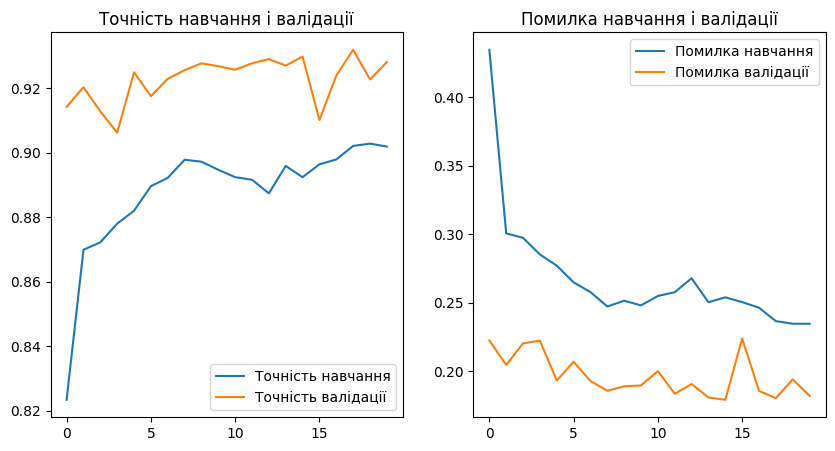

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Точність навчання')
plt.plot(val_acc, label='Точність валідації')
plt.legend(loc='lower right')
plt.title('Точність навчання і валідації')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Помилка навчання')
plt.plot(val_loss, label='Помилка валідації')
plt.legend(loc='upper right')
plt.title('Помилка навчання і валідації')
plt.show()

# 4) Тестування моделі

In [ ]:
model.evaluate(test_generator)

626/626 [==============================] - 103s 142ms/step - loss: 0.1637 - accuracy: 0.9352


[0.1636832356452942, 0.9352032542228699]

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

1/1 [==============================] - 0s 21ms/step


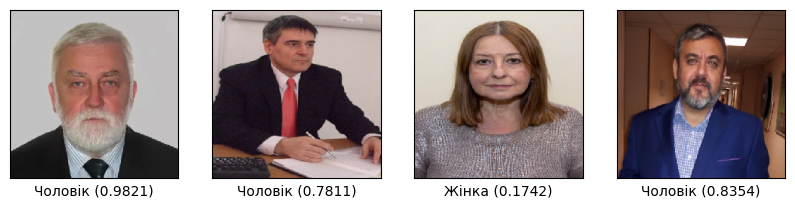

In [ ]:
test_img_names = ['Sinicyn.webp', 'Shevchenko.jpg', 'Derhilyova.jpg', 'Hrebennikov.jpg']
plt.figure(figsize=(10,4))
for i, img_name in enumerate(test_img_names):
    img = image.load_img(f"/content/drive/MyDrive/Colab Notebooks/gender-classifier/IPS_Test/{img_name}", target_size=target_size)
    img_array = image.img_to_array(img) / 255
    img_array = img_array.reshape(1, 224, 224, 3)

    prediction = model.predict(img_array, batch_size=1)
    prediction = round(float(prediction[0][0]), 4)
    label = 'Чоловік' if prediction > 0.5 else 'Жінка'

    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'{label} ({prediction})')
    plt.imshow(img)